# Pong Environment
Here, the input is the RAM of the Atari Pong environment.

The actions are, up, down, none.

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from functools import partial
from tqdm import tqdm_notebook as tqdm

from concurrent.futures import ProcessPoolExecutor

In [4]:
from utils.environment import add_energy, make_specs, run_env
from utils.model import get_params, set_params, get_action
from utils.genetic import CmaES

## Define Useful Features

In [5]:
jtplot_style()

## Load Environment

In [8]:
env = gym.make('Pong-ram-v0')

DependencyNotInstalled: No module named 'atari_py'. (HINT: you can install Atari dependencies by running 'pip install gym[atari]'.)

In [11]:
!pip install gym[atari]

  Using cached atari-py-0.1.1.tar.gz
  Running setup.py bdist_wheel for atari-py ... error
  Complete output from command /Users/Vaisakh/anaconda3/envs/genetic/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/kq/lvy6cycd4335v2zlxxmqmg7h0000gn/T/pip-build-_zf6d1lh/atari-py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /var/folders/kq/lvy6cycd4335v2zlxxmqmg7h0000gn/T/tmpuyrrfifvpip-wheel- --python-tag cp36:
  running bdist_wheel
  running build
  xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun
  Could not build atari-py: Command '['make', 'build', '-C', 'atari_py/ale_interface', '-j', '3']' returned non-zero exit status 1.. (HINT: are you sure cmake is installed? You might also be missing a library. Atari-py requires: zlib [installable as 'apt-get insta

In [7]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [8]:
add_energy(env)

# Create Model

In [9]:
get_model = lambda: nn.Linear(n_obs, n_act)

In [10]:
model = get_model()

# Create CMA-ES

In [11]:
class CmaES(ES):
    def __init__(self, evaluator, population_size, mean, surviving_fraction=0.25):
        super().__init__(population_size)
        self._evaluator = evaluator
        self._surviving_size = max(2, int(surviving_fraction * population_size))
            
        self._mean = mean
        self._population = [mean + torch.randn(len(mean)) 
                            for _ in range(population_size)]
        self._history.append((0, evaluator(mean)))
        
    def _strategy(self, num_workers):
        with ProcessPoolExecutor(num_workers) as executor: 
            fitnesses = list(executor.map(self._evaluator, self._population))
            
        fitness_ids = np.argsort(fitnesses)
        surviving_ids = fitness_ids[-self._surviving_size:]
        survivors = torch.stack([self._population[i] for i in surviving_ids])
        
        def cov(x, m):
            p = x - m
            return (p.unsqueeze(-1) * p.unsqueeze(1)).mean(0)
        
        self._cov = cov(survivors, self._mean)
        self._mean = survivors.mean(0)
        
        def _multivariate(mu, sigma):
            l = torch.from_numpy(np.linalg.cholesky(sigma.numpy()))
            return list(torch.mm(torch.randn(self._population_size - self._surviving_size,
                                             len(mu)), l))
        
        new_population = _multivariate(self._mean, self._cov) + list(survivors)
        
        fitness = fitnesses[surviving_ids[-1]]
        self._solution = survivors[-1]
        
        return new_population, fitness
    
    def solution(self):
        return self._solution

In [12]:
def evaluator(params, gamma=0, episodes=1):
    model = get_model()
    set_params(model, params)
    rewards, energies = run_env(env, lambda x: get_action(model, x), episodes)
    return rewards - gamma * energies

In [13]:
solver = CmaES(partial(evaluator, gamma=0.0, episodes=1), 100, 
                  torch.zeros(len(get_params(model))))

In [14]:
solver(4)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

-76.00


In [15]:
solver._cov.diag().mean()

0.8020099969137282

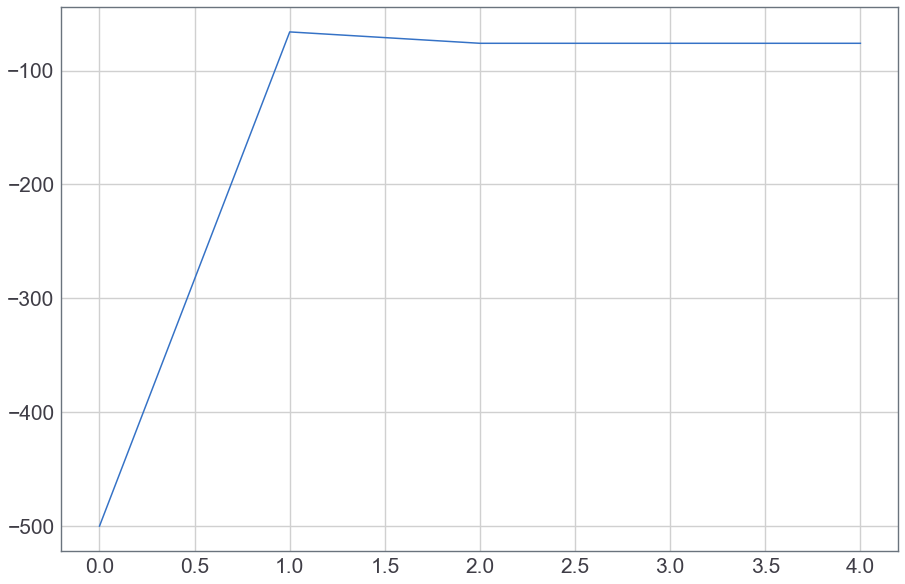

In [16]:
solver.plot_history()

In [17]:
set_params(model, solver.solution())

# Sample Model

In [21]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-475.0, 0)